# Optimize and train GPT-2

- The following is Part 2 of my extended write-up on building and training GPT-2 from scratch following along with ["Let's reproduce GPT-2 (124M)"](https://www.youtube.com/watch?v=l8pRSuU81PU) by Karpathy.  In this part, I discuss the optimizations that speed up training first on one, then multiple GPUs, also adding more detail where I felt necessary for my own understanding (hoping this will be helpful to others).

## Establishing a timing baseline

![my-gpus](./assets/gpu-usage-init.png)

- Each iteration would take about 720ms with batch size of 10 on a 3090 (vs 1000 on A100 with double the batch size!), so I expect my single-GPU training to be a bit slower than Andrej's.  With Andrej's A100, it's possible to process one epoch in 20 batches of size 16 with about 1000ms/batch, whereas with a 3090, it's possible to process one epoch in 33 batches of size 10 with 730ms/batch, so about 20% slower than Andrej's time (33x730/20x1000).
- Also, Andrej suggests using nice numbers that have lots of multiples of 2.  I tried a batch size of 8, but in this specific use case, I found that using batch size of 10 vs 8 is slightly faster per epoch on a 3090. 

- Also, to properly time the code, it's important to wait until the GPU processes a batch before the CPU times the work.  It's possible that the CPU has loaded a batch onto GPU, GPU is still processing it, and the CPU has moved on to record the end time for the operation. To prevent this from happening, use torch.cuda.synchronize():

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)
model = GPT(GPTConfig())
model.to(device)
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    t0 = time.time()
    x,y = train_loader.next_batch()
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x,y)
    #import code; code.interact(local=locals())
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish all the scheduled work
    t1= time.time()
    dt = (t1-t0)*1000 # time diff in seconds
    tokens_per_sec = (train_loader.B*train_loader.T)/(t1-t0)
    print(f'iteration {i}, loss = {loss.item()}, dt: {dt: .2f}ms, toks/sec: {tokens_per_sec:.2f}')

- We may change the batch size, so to get a more objective measure of training speed, look at tokens/second, which is 16.3K on an A100 and 14.1K on a 3090.

## Mixed precision logic

- First observe that we can check the type of the logits in our model by starting an interactive debugging session as below:

In [ ]:
train_loader = DataLoaderLite(B=4,T=32)
model = GPT(GPTConfig())
model.to(device)
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    x,y = train_loader.next_batch()
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x,y)
    import code; code.interact(local=locals())
    loss.backward()
    optimizer.step()
    print(f'iteration {i}, loss = {loss.item()}')
    

- Which yields

In [2]:
(InteractiveConsole)
>>> logits.dtype
torch.float32

- PyTorch supports up to FP64 precision, which is useful for scientific computing applications, but deep learning training can tolerate significantly lower precision than default FP32, however. 
- From A100 spec sheet, for example, it's possible to get 16x performance improvement by going down from FP32 to FP16 Tensor Core.
- For deep learning, sparsity feature is not currently used, so disregard the second number in a cell when it's present.
- We do not use INT8 for training since it implies a uniform distribution and we need a normal distribution provided by the float data types. INT8 is used for inference, however.
- The memory bandwidth of an A100 is 1935GB/s, and most well-tuned application are bound more by memory than by speed.  Lowering precision means tensors will take less space in memory, making it easier to satisfy the memory bandwidth constraint.  
- To summarize, by lowering precision, "we can store more and access it faster" (Andrej).

![Source: https://developer.nvidia.com/blog/nvidia-ampere-architecture-in-depth/](./assets/a100-specs-short.png)

## Tensor Cores

![Source: https://developer.nvidia.com/blog/programming-tensor-cores-cuda-9/](./assets/tensor-core.png)

- A Tensor Core is an instruction in a given architecture, in the case above for a 4x4 multiply and add operations.  Any time we have multiply (and less importantly add) operations, which compose the majority of our GPT-2 transformer, these operations will be performed using Tensor Cores.  For example, the classifier head matrix multiply going from 768 to 50257 dominates the computations in GPT-2.

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/tf32.png)

- With FP32 (torch.float32 default of PyTorch), both the input operands and the intermediate add/multiplies that compose individual elements of the result matrix are done in FP32. 
- We could switch to TF32, however, which uses the full 32 bits of FP32 for accumulator but just 19 bits for input operands due to lower number of mantissa bits as seen below:

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/exponent-mantissa.png)

- With TF32, we get an 8x speedup without needing to modify the code.  The outputs will still be in FP32 as seen below.  If our application can tolerate a little bit of imprecision, TF32 is a great option.  In practice,the difference between FP32 and TF32 is almost imperceptible. 

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/tf32-mechanics.png)

- On my 24GB 3090, I was able to use batch size of 8 (or 10 max) with sequence length of 1024 (Andrej got away with batch size of 16 on 40GB A100):

## Compute the speedup with TF32

- To enable TF32 in PyTorch, change the float32 matmul precision from it's default 'highest' to 'high' with torch.set_float32_matmul_precision('high'):

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)

torch.set_float32_matmul_precision('high')
...
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
   ...

- On an A100, throughput increases from 16.1K tokens/second to about 49K tokens/second, so *about a 3X speedup*. 
- On 3090, this leads to *only about 40% speedup* from 14.1K tokens/second baseline to 19.6K tokens/second.  
- While TF32 in principle offers an 8X speedup on an A100 (I couldn't find reliable official estimates for 3090 TF32 *tensor*), a lot of these workloads are memory bound.  Thus although a matrix multiplication could potentially happen 8X faster with TF32 compared to FP32, the output numbers are still FP32, and these get moved around through the memory system at a speed that's much slower than the GPU's ability to perform the calculations.  

## Bfloat16 to reduce memory bandwidth constraint 

- Let's review the following once again

![Source: https://images.nvidia.com/aem-dam/en-zz/Solutions/data-center/nvidia-ampere-architecture-whitepaper.pdf](./assets/exponent-mantissa.png)

- To address the memory bandwidth constraint, we can use Bfloat16 (BF16) to more aggressively crop the mantissa without changing the sign and exponent (range) of the number.  
- Originally, FP16 was used, but this number format has a reduced range, causing issues that were patched by gradient scalers and similar solutions that introduced additional state and complexity. BF16 addresses these problems by preserving the original range of number.
- Andrej recommends studying the torch.autocast portion of [mixed precision documentation](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html), which has a context manager *torch.autocast*.  This context manager is recommended around forward pass and loss calculation of the model only.
- We thus only need to add one line of code as below:

In [ ]:
for i in range(50):
    ...
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x,y)
    loss.backward()
    ...

- Using an interactive console breakpoint

In [14]:
for i in range(50):
    ...
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x,y)
        import code; code.interact(local=locals())

    loss.backward()
    ...

- We see that logits.dtype is indeed torch.bfloat16.  Our weights remain in FP32, however, as model.transformer.wte.weight.dtype is torch.float32.  This implies a mixed precision: PyTorch is keeping certain weights in full precision while converting others to bfloat16.  What gets converted at what point is not exactly clear, but the general guidelines are below:

![Source: https://pytorch.org/docs/stable/amp.html](./assets/tf32-vs-bfloat16-what-converts.png)

- Thus matrix multiplications, addition, etc. get converted while layer norms, softmax, etc. do not since they are less robust to precision changes.

- On an A100, our previous benchmark is 50K tokens/second and it goes up to 55K tokens/second with bfloat16, about a 10% speedup.
- On a 3090, our previous benchmark is 19.6K tokens/second and it goes up to 27.5K tokens/second with bfloat16, about a 40% speedup, suggesting that 3090 was perhaps more memory-bound than the A100.


## Torch.compile, a compiler for neural networks

In [ ]:
train_loader = DataLoaderLite(B=10,T=1024)

torch.set_float32_matmul_precision('high')

model = GPT(GPTConfig())
model.to(device)
# torch.compile only needs a single line
model = torch.compile(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    ...

- The first iteration with torch.compile will typically be slower since PyTorch takes time to compile the code at the start.
- On an A100 with batch size of 16, Andrej observed a 2.3x improvement from using torch.compile. 
- On a 3090 with batch size of 10, no improvement was seen during the first run (27.4 K tokens/second -> 26.8K tokens/second). However, switching down to batch size of 8 yielded a significant increase *the first time around*.  However, when I repeated the experiment, torch.compile ended up being faster with batch size of 10 again!  This could have been due to graph breaks or kernel launch overhead.  
- Taking the best runtime with torch.compile and batch size of 10, 27.4 K -> 41.7 K tokens/second, or about 48% speedup over mixed precision benchmark. 

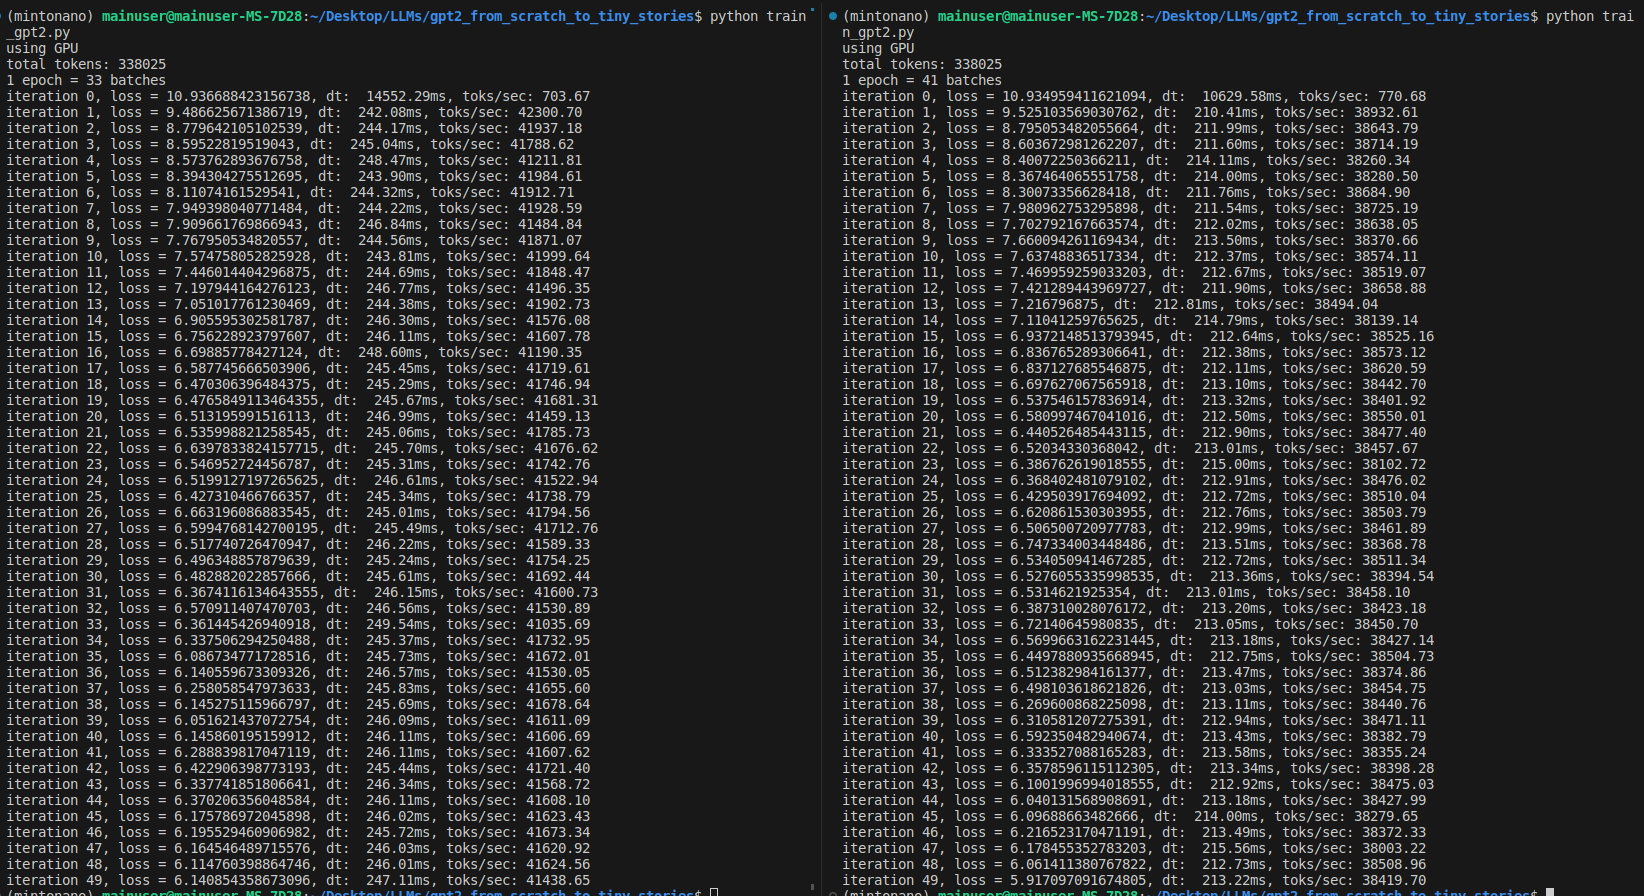

- torch.compile does the following:
    - Take out the Python interpreter from the forward pass and compile the neural net as a single object
    - Reduce GPU read/writes as demonstrated in the following example. Suppose we didn't use torch.compile and instead of nn.GELU in our MLP, we used our own custom implementation below:
    ```python
    class TanhGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi)*(x + 0.044715 * torch.pow(x, 3.0))))
    ```
    - Looking at the following [diagram](https://developer.nvidia.com/blog/improving-gpu-memory-oversubscription-performance/), the input would first need to be placed from the High-Bandwidth Memory (HBM) onto the GPU for the torch.pow(x, 3.0) computation.  Once the results are computed, they would be sent back to HBM.  Next the computed result would be sent back to be multiplied by 0.044715 and so on. This would results many reads and writes to and from GPU and HBM, which are the bottleneck in many modern system.
    - Since all the operations in the custom TanhGELU are element-wise operations, torch.compile can move the input to GPU and, for every single element, perform all the operations while the memory is on the GPU, then write back a single time.  This is an example of *kernel fusion*, a major way in which torch.compile creates a speedup.  

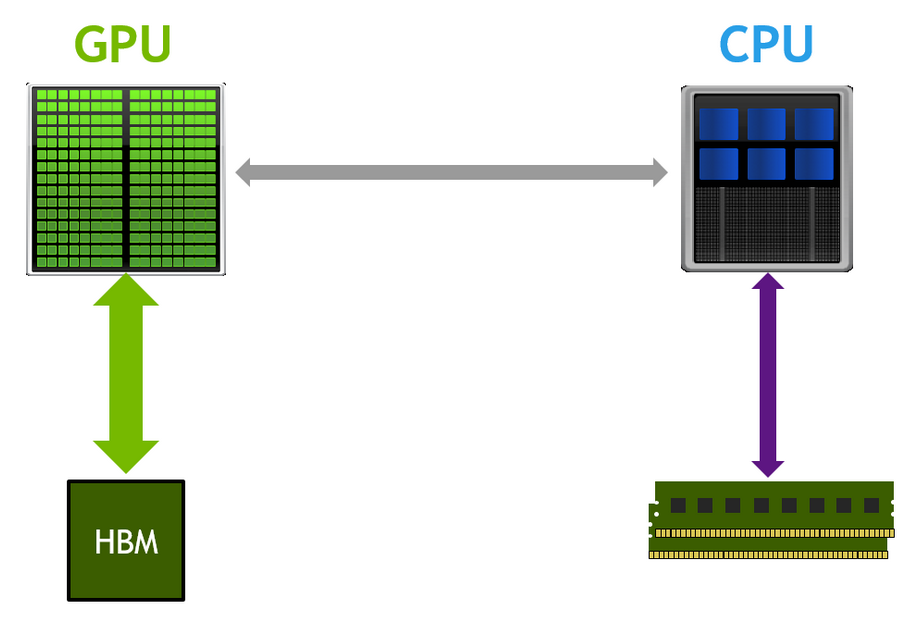

- In addition, when the data is moved to GPU for element-wise operations, it will need intermediate memory, a small amount of which is found on the GPU. Andrej points out that on the GPU chip itself, there is L2 cache. On the streaming multiprocessors (SMs) that do the calculation, there's L1 memory and registers.  These use SRAM for fast access times and low power consumption vs transistors and capacitors implementation of HBM.  Below is a typical diagram of memory and associated access speeds from Dao et al. (2022), Figure 1:

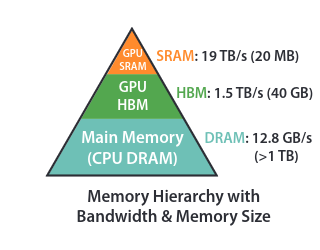


- With mixed precision and torch.compile optimizations, Andrej's training on an A100 is about 3X faster than training on a 3090, with 125K tokens/second processed on an A100 and 41.5K tokens/second on a 3090.

## FlashAttention

- The attention operation is currently composed of the four lines of code highlighted below:

In [6]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        ...
    def forward(self, x):
        ...
        v = v.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        # -----Start: attention operation-----
        att = (q @ k.transpose(-2,-1))*(1.0/math.sqrt(k.size(-1))) # (B, nh, T, hs) x (B, nh, hs, T) = (B, nh, T, T)
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) = (B, nh, T, hs)
        # -----End: attention operation-----
        y = y.transpose(1,2).contiguous().view(B, T, C) 
        ...


- FlashAttention is a kernel fusion operation that torch.compile cannot find currently.  This is because kernel fusion requires an algorithmic rewrite of how attention is currently implemented.  While FlashAttention requires more FLOPs, it ends up being significantly faster because of its judicious use of the memory hierarchy, which leads to fewer read/writes between GPU and HBM.  
- In particular, the NxN attention matrix is never read from/written to HBM.  It's simple to perform the matrix multiplications in a streaming manner, but computing softmax this way is more of a challenge.  The crux of the algorithmic rewrite is the online softmax trick, which incrementally computes the softmax without needing all the inputs as is customary for standard softmax normalization.  The key insight is that the softmax function can be broken down into smaller chunks, computed independently on GPU, and then combined using a 'softmax trick' formula. This enables FlashAttention to process long sequences more efficiently, without having to materialize the entire attention matrix at once.  
- In more detail, from p.5 of Dao et al. (2022), the softmax trick uses intermediate *m* and *l* variables that combine the statistics from individual 'attention submatrices' to reconstruct the softmax for the entire attention matrix.  
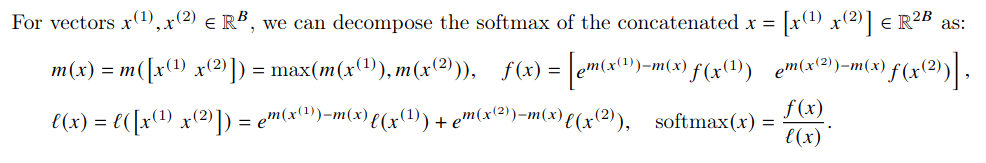


- With FlashAttention in place, the four lines above become one line in the following code:

In [ ]:

class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        ...
    def forward(self, x):
        ...
        v = v.view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        # -----Start: attention operation-----
        y = F.scaled_dot_product_attention(q,k,v, is_causal=True)
        # -----End: attention operation-----
        y = y.transpose(1,2).contiguous().view(B, T, C) 
        ...


- The loss after 50 iterations is identical to what it was before since FlashAttention is *exact* attention, not an approximation, so identical operations are performed.  However, 
on a 3090, with FlashAttention added, about 50K tokens/second can be processed compared 41.7K tokens/second with just mixed precision+torch.compile, hence about a 20% speedup.  On an A100, Andrej obtained about a 27% improvement.  

## Nice and ugly numbers, vocab size

- We're looking for the numbers in our transformer to have as many powers of two as possible since GPU kernels work best with these.  In particular, *vocab_size* is 50257, which is not odd; one simple way to change this is to round it up to 50304, which divides by 128 (2**7).  This adds 'fake' tokens and increases the amount of computation, yet by working better with the GPU, it would generally lead to a speedup in training.
- Note that the vocab_size appears in the embedding and the classifier layer, and the extra tokens added there would never be used.  The weight sharing implies that the network has to learn that the logits associated with the extra added rows need to be driven to zero, which is similar to how it is already learning to drive down weights for tokens not encountered in our training set.
- On an A100, 4% improvement was observed;  on a 3090, the training speed increased from 50K tokens/second to about 53 tokens/second, so about a 6% increase.
- Andrej elaborates on the reason for the speedup.  Many of the CUDA kernels use block tiles, which are usually 'nice numbers' with many powers of 6, so calculations are done in powers of 64 or 32, for example.  When the desired calculation does not neatly fit into these block tiles, less efficient boundary kernels come in to do the last part at the second pass.  

- Optimizations targeted at GPT-2 specifically follow next.

## Gradient clipping

- The idea with gradient clipping is that it's possible to get a particularly 'unlucky' batch during training, which would lead to high loss and gradient, leading to training instability (or 'shock', as Andrej puts it).  

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for i in range(50):
    ...
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    ...

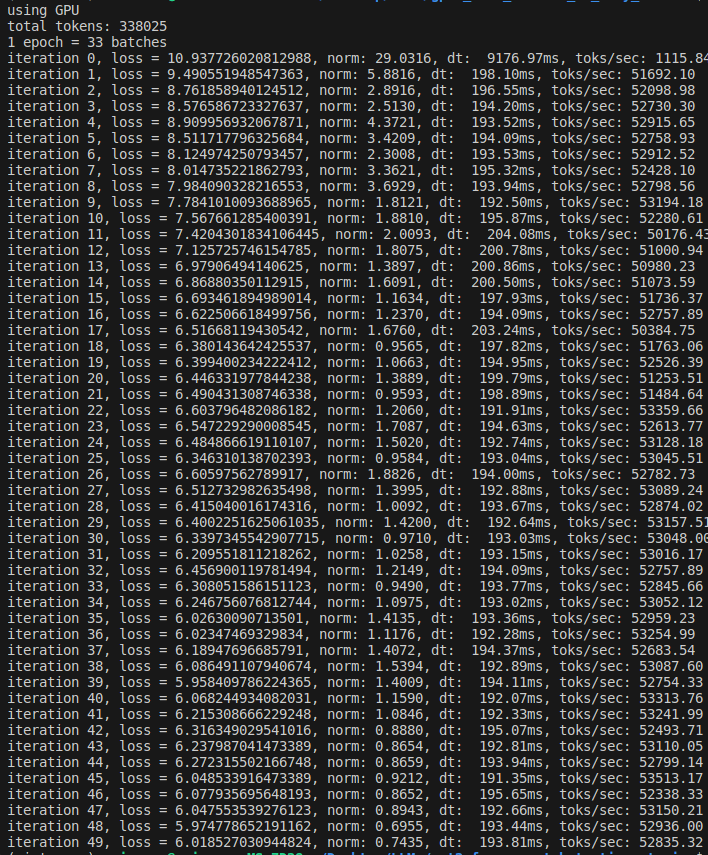

- Note that the norm is still high at the start of the training.  Since the weights are randomly initialized, a lot of learning happens to (generally) drive down the biases of the output tokens.  The norm then stabilizes to be around 1.0.

## Learning rate scheduler

- The learning rate scheduler used is cosine decay learning rate scheduler.  
    - There is a linear warmup step as it's beneficial to have a low learning rate at the start since the network is randomly initialized. 
    - After that, the cosine decay takes place and the learning rate is gradually reduced to 10% of its original value. 
    - Taking the values for warmup steps and maximum number of steps from the GPT-3 paper (GPT-2 was scarce on training details), we see the following graph of learning rates:

Text(0.5, 0, 'Number of tokens processed by GPT-2 in millions')

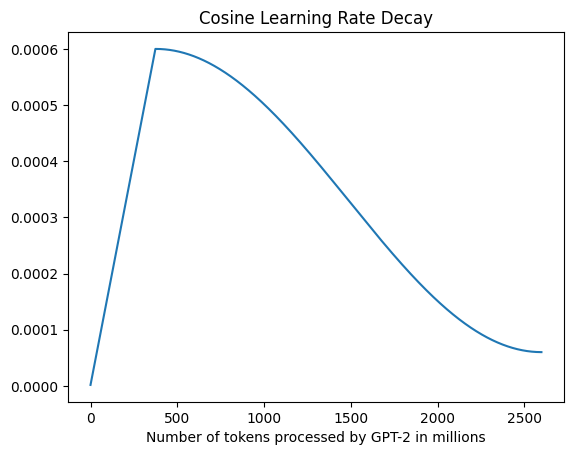

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 375
max_steps = 2600
def get_lr(it):
    # 1.) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1)/warmup_steps
    # 2.) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3.) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps)/(max_steps-warmup_steps)
    assert 0<=decay_ratio<=1
    coeff = 0.5*(1.0 + math.cos(math.pi * decay_ratio)) # coef starts at 1 and goes to 0
    return min_lr + coeff * (max_lr-min_lr)

its = np.arange(0,max_steps)
get_lr_vectorized = np.vectorize(get_lr)
lrs = get_lr_vectorized(its)
plt.plot(its,lrs)
plt.title('Cosine Learning Rate Decay')
plt.xlabel("Number of tokens processed by GPT-2 in millions")

- I chose to express the x-axis in tokens rather than steps to reduce the focus on hardware-related configurations used to train GPT-2 (eg, batch size), but the shape would be identical.  
- The learning rate scheduling can be added to the training loop in the code below:

In [ ]:
# ----------------- Training loop -----------------
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
for step in range(50):
    ...
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    ...

- Note that as part of setting the learning rate, we need to iterate through the parameter groups (of which there's only one) and set the 'lr' parameter to our learning rate. This is a bit clunky, but Andrej's impression is that it's the way to do this in PyTorch currently.  An alternative would be to use an off-the-shelf learning rates scheduler from PyTorch, but that's an additional abstraction, and get_lr is composed of only a few lines of highly readable code.
- Andrej points out that the choice of a learning rate scheduler is up to the user and determining the 'best' one is an active area or research.

- In addition, Andrej skips the gradual batch size increase used by GPT-2 since it complicates the arithmetic of the number of tokens used at each step in the optimization and it's not a major improvement. 

## Weight decay and fused optimizer

- Decaying weights prevents any weight from getting too large, forcing the network to distribute the work. 
- Instead of iterating over all the parameter updates, the kernels (computations) used for the AdamW update can be fused into a single kernel in more recent versions of PyTorch.

In [ ]:
class GPT(nn.Module):
    ...
    
    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters that require grad
        param_dict = {pn: p for pn,p in self.named_parameters()}
        param_dict = {pn: p for pn,p in param_dict.items() if p.requires_grad}
        # create optim groups: any 2D parameter weight decays, others don't:
        # weight tensors in matmuls + embeddings will decay, biases and layernorms will not
        decay_params = [p for n,p in param_dict.items() if p.dim()>=2]
        nodecay_params = [p for n,p in param_dict.items() if p.dim()<2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decay param tensors: {len(decay_params)} with {num_decay_params} parameters")
        print(f"num non-decay param tensors: {len(nodecay_params)} with {num_nodecay_params} parameters")

        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        print(f'using fused AdamW: {use_fused}')
        optimizer = torch.optim.AdamW(optim_groups, lr = learning_rate, betas=(0.9, 0.95), eps = 1e-8, fused=use_fused)
        return optimizer
# In the training loop replace the optimizer below:
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
optimizer = model.configure_optimizers(weight_decay = 0.1, learning_rate = 6e-4, device_type = device)
for step in range(50):
    ...

- Among the output, we will see num decay param tensors: 50 with 124354560 parameters, num non-decay param tensors: 98 with 121344 parameters.  Hence most of the parameters will be weight decayed. 
- On an A100, Andrej observed about a 3% speedup due to the fused optimizer, while I saw about a 2% speedup on a 3090.

## Gradient accumulation

- The relationship between weight decay, batch size, and learning rate is quite complex.  In GPT-2, smaller batch size and bigger learning rate was likely used for smaller neural networks and larger batch size with smaller learning rate for larger ones.  For the smallest network size, OpenAI used a batch size of 0.5M tokens. With 1024 tokens/batch, this implies a batch size of about 500.  However, we would still like to use the effective batch size of 0.5M since it's related to other hyperparameters determined by OpenAI.  A solution to this is *gradient accumulation*, which allows us to simulate in a serial way any arbitrary batch size of our choice.  

In [3]:
# ----------------- Batch size -----------------
total_batch_size = 524288 # 2**19 ~ 0.5M
B = 8 # micro batch size on a 3090; switching down 10->8 since speeds are comparable and it factors evenly into total_batch_size above
T = 1024
assert total_batch_size % (B*T) == 0, 'make sure total_batch_size is divisible by B*T'
grad_accum_steps = total_batch_size//(B*T)
print(f"total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation: {grad_accum_steps}")

total desired batch size: 524288
=> calculated gradient accumulation: 64


- Thus we'll need to do 64 forward backward steps followed by a single gradient update.  For context, our current training loop is 

In [ ]:

# ----------------- Training loop -----------------
optimizer = model.configure_optimizers(weight_decay = 0.1, learning_rate = 6e-4, device_type = device)
for step in range(50):
    t0 = time.time()
    x,y = train_loader.next_batch()
    x,y = x.to(device), y.to(device)
    optimizer.zero_grad()
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x,y)
        #import code; code.interact(local=locals())
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize() # wait for GPU to finish all the scheduled work
    t1= time.time()
    dt = (t1-t0)*1000 # time diff in seconds
    tokens_per_sec = (train_loader.B*train_loader.T)/(t1-t0)
    print(f'iteration {step}, loss = {loss.item()}, norm: {norm:.4f}, lr: {lr:.4e}, dt: {dt: .2f}ms, toks/sec: {tokens_per_sec:.2f}')

- To replicate the effective batch size of around 0.5M, we can accumulate gradients using an inner for loop, track accumulated loss to print it correctly, and adjust the tokens per second calculation to account for the number of gradient accumulation steps:

In [ ]:
# ----------------- Training loop -----------------
optimizer = model.configure_optimizers(weight_decay = 0.1, learning_rate = 6e-4, device_type = device)
for step in range(50):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0 # need this  to correctly print the accumulated loss
    for micro_step in range(grad_accum_steps):
        x,y = train_loader.next_batch()
        x,y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x,y)
        loss = loss/grad_accum_steps
        loss_accum += loss.detach() # don't need to backpropagate through accumulation process
        loss.backward() # deposits gradients by default
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    ...
    tokens_per_sec = (train_loader.B*train_loader.T*grad_accum_steps)/(t1-t0) # don't forget to adjust the tokens/second calculation 
    print(f'iteration {step}, loss = {loss_accum.item():.6f}, norm: {norm:.4f}, lr: {lr:.4e}, dt: {dt: .2f}ms, toks/sec: {tokens_per_sec:.2f}')


- Note in particular that the loss needs to be divided by *grad_accum_steps*. This is because the accumulator in F.cross_entropy loss is *mean*, whereas the loss within each grad_accum_steps loop does not account for averaging with the *grad_accum_steps*.  To make this more concrete, without the gradient accumulation, the loss in the following simple regression example would include the division by 4:

In [7]:
import torch

net = torch.nn.Sequential(
    torch.nn.Linear(16,32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)
torch.random.manual_seed(42)
x = torch.randn(4,16)
y = torch.randn(4,1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat,y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# The loss objective, due to reduction='mean' is
# L = 1/4*[
#     (y[0]-yhat[0])**2 +
#     (y[1]-yhat[1])**2 +
#     (y[2]-yhat[2])**2 +
#     (y[3]-yhat[3])**2 
# ]

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


- If we compute the loss by adding the losses of the individual examples, we omit division by 4:

In [8]:
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat,y[i])
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])
# The loss objective without reduction='mean' is
# L = [
#     (y[0]-yhat[0])**2 +
#     (y[1]-yhat[1])**2 +
#     (y[2]-yhat[2])**2 +
#     (y[3]-yhat[3])**2 
# ]

tensor([-0.0598,  0.0042,  0.0167, -0.0161,  0.0235, -0.0320, -0.0311, -0.0550,
        -0.0410, -0.0536])


- Clearly, the gradients are not the same.  To fix this, divide the loss by number of steps:

In [9]:
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat,y[i])
    loss = loss/4
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])
# The loss objective without reduction='mean' is
# L = [
#     (1/4)*(y[0]-yhat[0])**2 +
#     (1/4)*(y[1]-yhat[1])**2 +
#     (1/4)*(y[2]-yhat[2])**2 +
#     (1/4)*(y[3]-yhat[3])**2 
# ]

tensor([-0.0150,  0.0011,  0.0042, -0.0040,  0.0059, -0.0080, -0.0078, -0.0138,
        -0.0103, -0.0134])


- Also note that casting our training loop in terms of effective batch size, we can adjust the size of our micro batch without changing the training dynamics: micro batch size is purely a performance optimization setting.  

## Distributed data parallel (DDP)

- With DDP, we'll have one process per GPU available.  These will have the same model loaded but will be processing slightly different parts of the data.  They'll contribute their own gradients that will be averaged.  DDP can be run with *torchrun*, which will correctly set the necessary environmental variables and launch distributed training.

### Initialize DDP

- Where we were before initializing device, we now also initialize distributed training as follows:

In [ ]:
# ----------------- Run distributed training -----------------
from torch.distributed import init_process_group, destroy_process_group
ddp = int(os.environ.get('RANK',-1)) != -1 # is this a ddp run?
if ddp:
    assert torch.cuda.is_available()
    init_process_group(backend='nccl')
    ddp_rank = int(os.environ.get("RANK"))
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    device = f"cuda:{ddp_local_rank}"
    torch.cuda.set_device(device)
    master_process = ddp_rank==0
    print("RANKS: ",ddp_rank,ddp_local_rank,ddp_world_size,device)
else:
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    device = f"cuda: {ddp_local_rank}"
    master_process = True
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
        print("using GPU")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
        print("using MPS")


- There is a *RANK* variable assigned to each GPU (GPU 0 will have *RANK* of 0, GPU 1 will have *RANK* of 1, etc).  Each of these processes will run on different parts of the data.  *LOCAL_RANK* is only used in multi-node setting and represents the rank of a GPU on a single node.  *WORLD_SIZE* is the total number of GPUs available.   

### Batch size adjustments

- Since each GPU will need to run on a slightly different subset of our data, adjust the batch size and gradient accumulation as follows:

In [ ]:
# ----------------- Batch size -----------------
total_batch_size = 524288 # 2**19 ~ 0.5M
B = 8 # micro batch size on a 3090
T = 1024
assert total_batch_size % (B*T*ddp_world_size) == 0, 'make sure total_batch_size is divisible by B*T*ddp_world_size'
grad_accum_steps = total_batch_size//(B*T*ddp_world_size)
if master_process:
    print(f"total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation: {grad_accum_steps}")

- Also, print on master process only to avoid duplicates prints arising from other processes.

### Running DDP with *torchrun*

To run on 2 GPUs, we can use *torchrun --standalone --nproc_per_node=2 train_gpt2.py * (adjust 2 to the number of available GPUs).

### DataLoader modifications

In [ ]:
# ----------------- Data loader lite -----------------
import tiktoken
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes): #1
        self.B = B
        self.T = T
        self.process_rank = process_rank                   #2
        self.num_processes = num_processes                 #3
        # load the data from disk into memory
        with open("input.txt", "r") as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        self.tokens = torch.tensor(enc.encode(text))
        print(f"total tokens: {len(self.tokens)}")
        print(f"1 epoch = {len(self.tokens)//(B*T)} batches")
    
        self.current_position = self.B*self.T*self.process_rank
    
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position:self.current_position+B*T+1]
        x = (buf[:-1]).view(B,T)
        y = (buf[1:]).view(B,T)
        self.current_position += B*T*self.num_processes                            #4
        # if run out of tokens, loop around to zero
        if self.current_position + (B*T*self.num_processes+1) >= len(self.tokens): #5
            self.current_position = self.B*self.T*self.process_rank                #6
        return x, y
...
train_loader = DataLoaderLite(B=B,T=T, process_rank=ddp_rank, num_processes=ddp_world_size)


- The dataloader should now advance by *B x T x num_processes* so that each process (GPU) gets its own batch.  To accomplish this, modify/add lines commented with #1-#6.  

### Model modifications

- Currently, identical model copies are initialized and compiled on each of the GPUs since each GPU is passes the same seed. In addition wrap the compiled model in a DDP container as follows:

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP
...
model = torch.compile(model)
if ddp:
    model = DDP(model,device_ids=[ddp_local_rank])

- In essence, DDP allows communication between the GPUs by averaging and synching the gradients.    The forward pass will be identical, but once the backward pass is over, DDP will call *allreduce* to get the average across all the GPUs and deposit the average on every single GPU. In addition, DDP efficiently communicates the gradients while the backward pass is happening.

- In addition, we should configure our optimizer using the 'raw' model that's not wrapped in the DDP process:

In [ ]:
raw_model = model.module if ddp else model # always contains the unwrapped model
...
optimizer = raw_model.configure_optimizers(weight_decay = 0.1, learning_rate = 6e-4, device_type = device)

### Training loop modifications

- In addition, we only need the average of the gradients at the last of the gradient accumulation steps. The sanctioned way to do this is with *ddp.no_sync* context manager.  Andrej notes that the context manager simply toggles the *require_backward_grad_sync* variable, noting that this is a risky move in case this variable disappears/gets renamed in future PyTorch versions.

In [ ]:
import torch.distributed as dist
...
# ----------------- Training loop -----------------
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
optimizer = model.configure_optimizers(weight_decay = 0.1, learning_rate = 6e-4, device_type = device)
for step in range(max_steps):
    ...
    for micro_step in range(grad_accum_steps):
        ...
        loss_accum += loss.detach() # don't need to backpropagate through accumulation process
        if ddp: 
            model.require_backward_grad_sync = (micro_step==grad_accum_steps-1)
        loss.backward() # deposits gradients by default
    if ddp:
        dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
    ...
    tokens_per_sec = (train_loader.B*train_loader.T*grad_accum_steps*ddp_world_size)/(t1-t0)
    if master_process:
        print(f'iteration {step}, loss = {loss_accum.item():.6f}, norm: {norm:.4f}, lr: {lr:.4e}, dt: {dt: .2f}ms, toks/sec: {tokens_per_sec:.2f}')
if ddp:
    destroy_process_group()

- Also, we want the average of all the losses from all the GPUs to be printed by the master process.  The *loss_accum* tensor exists on all the ranks.  Calling *dist.all_reduce* after the inner micro batch loop computes the average of *loss_accum*s and deposits it on all the ranks.  When we then print on the master process, the *loss_accum* that's identical on all the ranks is printed.  
- We should also destroy the process group after the training is done to free up resources. 

### Other tweaks, training dynamics

- Also, I got an error regarding *device_type* first time I ran the training.  Andrej noted in is code "added after the video, pytorch can be serious about it's device vs. device_type distinction".  This can be addressed as follows:

In [ ]:
# add after ddp init code
device_type = "cuda" if device.startswith("cuda") else "cpu"
# set device type to device_type in the training loop
with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
    logits, loss = model(x,y)

- We get the following training dynamics on two 3090s:

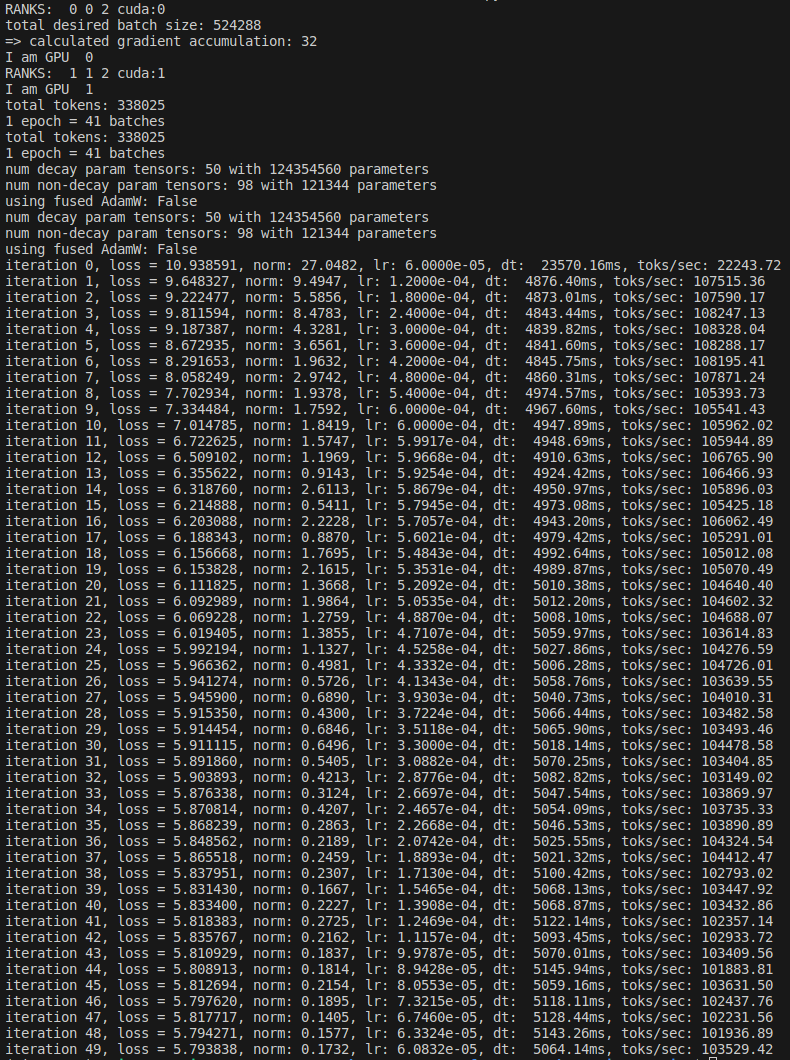

- The loss is going down smoothly and about 100K tokens/second are processed.  This is far short of 1.5M tokens/second that can be processed on 8xA100's, of course, but it still looks like training GPT-2 locally should be feasible.  Andrej later mentions that the 'full' trained GPT-2 can be reproduced in his setup in about an hour, so it would take around 15 hours on two 3090s.  
- In addition, Andrej mentioned that our current setup fixes the effective batch size, leaving the size of the micro batch as a tunable parameter.  While the following choice slightly violates the "nice numbers" principle, I think it's worth considering: Adjusting the effective batch to 512K and batch size to 10 so that micro batches with sequence length of 1024 evenly fit into the effective batch size, I could get the training to speed up to ~110K tokens/second, implying that the training time can be shortened to around 14 hours.  

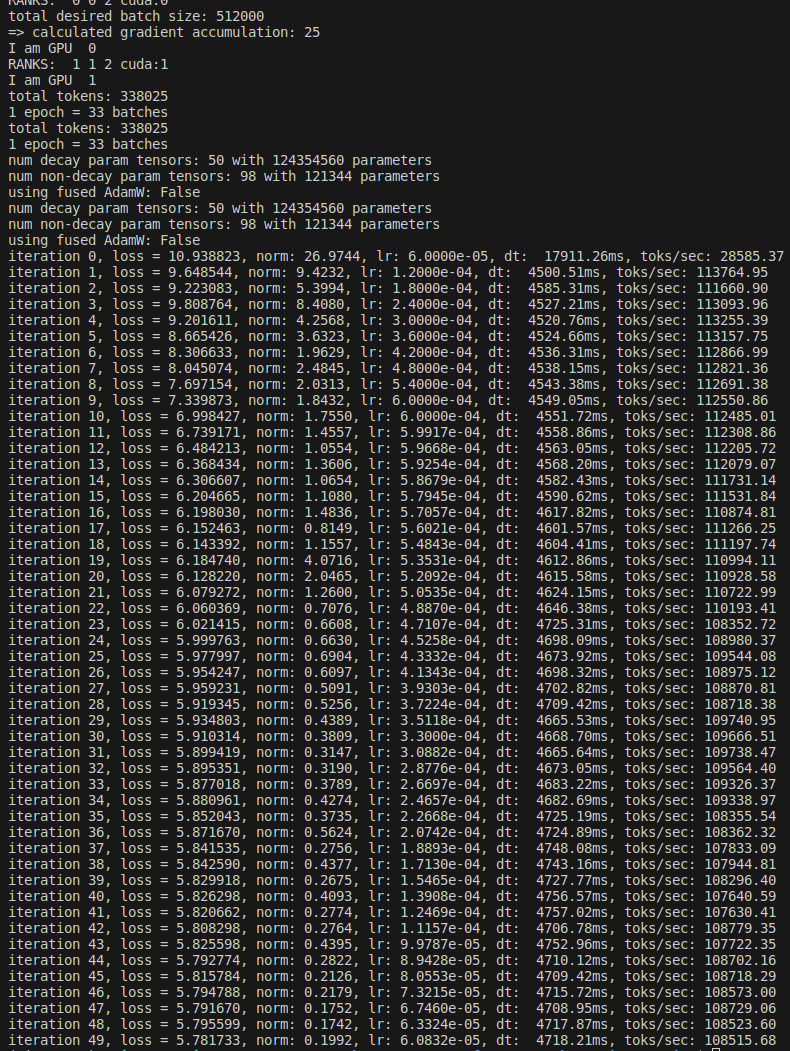

## References

Dao, Tri, Daniel Y. Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness." arXiv preprint arXiv:2205.14135v2 (2022).